# Streaming History analysis

## 0. Import data and packages

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv(r'./data/streaming_data_clean.csv')

In [3]:
df.head()

,Unnamed: 0,endTime,artistName,trackName,msPlayed,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,explicit,popularity
0,0,2019-12-28 18:17,Ghost,Cirice,113840,0.555,0.798,3.0,-5.658,1.0,0.0279,0.002540,0.000015,0.1710,0.284,89.987,audio_features,3ZXZ9RMsznqgyHnyq0K5FL,spotify:track:3ZXZ9RMsznqgyHnyq0K5FL,https://api.spotify.com/v1/tracks/3ZXZ9RMsznqg...,https://api.spotify.com/v1/audio-analysis/3ZXZ...,362093.0,4.0,False,57.0
1,1,2019-12-29 12:57,Ghost,Year Zero,6976,0.469,0.705,7.0,-5.134,1.0,0.0458,0.030400,0.015500,0.6590,0.137,122.025,audio_features,1YBf7Tq9bpcVwvnlP8YbQS,spotify:track:1YBf7Tq9bpcVwvnlP8YbQS,https://api.spotify.com/v1/tracks/1YBf7Tq9bpcV...,https://api.spotify.com/v1/audio-analysis/1YBf...,350187.0,4.0,True,53.0
2,2,2019-12-29 12:58,Rise Against,Intro/Chamber The Cartridge,33215,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,audio_features,0aHUJdrNRAVrrdDyUwHYn6,spotify:track:0aHUJdrNRAVrrdDyUwHYn6,https://api.spotify.com/v1/tracks/0aHUJdrNRAVr...,https://api.spotify.com/v1/audio-analysis/0aHU...,214907.0,4.0,False,34.0
3,3,2019-12-29 12:58,Rise Against,Intro/Chamber The Cartridge,860,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,audio_features,0aHUJdrNRAVrrdDyUwHYn6,spotify:track:0aHUJdrNRAVrrdDyUwHYn6,https://api.spotify.com/v1/tracks/0aHUJdrNRAVr...,https://api.spotify.com/v1/audio-analysis/0aHU...,214907.0,4.0,False,34.0
4,4,2019-12-29 13:01,Rise Against,Injection,210846,0.420,0.996,8.0,-2.961,0.0,0.0804,0.000229,0.000420,0.0897,0.433,105.686,audio_features,1wVUjggKup9hP2jd24gLSg,spotify:track:1wVUjggKup9hP2jd24gLSg,https://api.spotify.com/v1/tracks/1wVUjggKup9h...,https://api.spotify.com/v1/audio-analysis/1wVU...,199213.0,4.0,False,50.0


In [4]:
df.shape

(20406, 25)

## 1. Data Cleaning

### 1.1 Remove variables
Doing some removal of variables that don't provide any aditional insight

In [5]:
df.columns

Index(['Unnamed: 0', 'endTime', 'artistName', 'trackName', 'msPlayed',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'explicit', 'popularity'],
      dtype='object')

In [6]:
vars_exclude = ['Unnamed: 0', 'uri', 'track_href', 'analysis_url', 'type', 'id'] # all of these variables provide information with weblinks to spotify for either analysis from Spotify
df['id_stream'] = np.arange(0, df.shape[0], 1) # make id more readable

vars_keep = [var for var in df.columns if var not in vars_exclude]

df_filtered = df[vars_keep]

print(f"We removed {df.shape[1] - df_filtered.shape[1]} variables")

We removed 6 variables


### 1.2 Missing values

In [7]:
df_filtered.isnull().sum()

endTime                0
artistName             0
trackName              0
msPlayed               0
danceability        2002
energy              2002
key                 2002
loudness            2002
mode                2002
speechiness         2002
acousticness        2002
instrumentalness    2002
liveness            2002
valence             2002
tempo               2002
duration_ms         2002
time_signature      2002
explicit            2002
popularity          2002
id_stream              0
dtype: int64

In [8]:
missing_stream_data = df_filtered['popularity'].isnull().sum()
print(f"We have {missing_stream_data} streams with missing features, which accounts for {(missing_stream_data / df_filtered.shape[0]):.2%} of the data")

We have 2002 streams with missing features, which accounts for 9.81% of the data


In [9]:
df_clean = df_filtered.dropna().reset_index(drop = True)
df_clean.isnull().sum()

endTime             0
artistName          0
trackName           0
msPlayed            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
explicit            0
popularity          0
id_stream           0
dtype: int64

### 1.3 Creating new features

In [11]:
df_clean['timeStamp'] = pd.to_datetime(df_clean.endTime)

In [12]:
df_clean['streamDate'] = df_clean.timeStamp.dt.date # for date
df_clean['streamTime'] = df_clean.timeStamp.dt.time # for time

df_clean['streamYear'] = df_clean.apply(lambda row: row.timeStamp.year, axis = 1) # for year
df_clean['streamMonth'] = df_clean.apply(lambda row: row.timeStamp.month, axis = 1) # for month
df_clean['streamDay'] = df_clean.apply(lambda row: row.timeStamp.day, axis = 1) # for day
df_clean['streamHour'] = df_clean.apply(lambda row: row.timeStamp.hour, axis = 1) # for hour
df_clean['streamWeekDay'] = df_clean.apply(lambda row: row.timeStamp.weekday(), axis = 1) # for hour

df_clean.drop(['endTime'], axis = 1, inplace = True) # We can drop this

In [13]:
df_clean.head()

,artistName,trackName,msPlayed,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,popularity,id_stream,timeStamp,streamDate,streamTime,streamYear,streamMonth,streamDay,streamHour,streamWeekDay
0,Ghost,Cirice,113840,0.555,0.798,3.0,-5.658,1.0,0.0279,0.002540,0.000015,0.1710,0.284,89.987,362093.0,4.0,False,57.0,0,2019-12-28 18:17:00,2019-12-28,18:17:00,2019,12,28,18,5
1,Ghost,Year Zero,6976,0.469,0.705,7.0,-5.134,1.0,0.0458,0.030400,0.015500,0.6590,0.137,122.025,350187.0,4.0,True,53.0,1,2019-12-29 12:57:00,2019-12-29,12:57:00,2019,12,29,12,6
2,Rise Against,Intro/Chamber The Cartridge,33215,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,214907.0,4.0,False,34.0,2,2019-12-29 12:58:00,2019-12-29,12:58:00,2019,12,29,12,6
3,Rise Against,Intro/Chamber The Cartridge,860,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,214907.0,4.0,False,34.0,3,2019-12-29 12:58:00,2019-12-29,12:58:00,2019,12,29,12,6
4,Rise Against,Injection,210846,0.420,0.996,8.0,-2.961,0.0,0.0804,0.000229,0.000420,0.0897,0.433,105.686,199213.0,4.0,False,50.0,4,2019-12-29 13:01:00,2019-12-29,13:01:00,2019,12,29,13,6


In [14]:
col         = 'streamWeekDay'
conditions  = [ df_clean[col] == 0, df_clean[col] == 1, df_clean[col] == 2, df_clean[col] == 3, df_clean[col] == 4,
              df_clean[col] == 5, df_clean[col] == 6]
weekdays    = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    
df_clean["streamWeekDay_str"] = np.select(conditions, weekdays, default=np.nan)

### 1.4 Creating lists based on datatypes

In [15]:
df_clean.dtypes

artistName                   object
trackName                    object
msPlayed                      int64
danceability                float64
energy                      float64
key                         float64
loudness                    float64
mode                        float64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                 float64
time_signature              float64
explicit                     object
popularity                  float64
id_stream                     int32
timeStamp            datetime64[ns]
streamDate                   object
streamTime                   object
streamYear                    int64
streamMonth                   int64
streamDay                     int64
streamHour                    int64
streamWeekDay                 int64
streamWeekDay_str           

In [16]:
time = [var 
        for var in df_clean.columns 
        if var.startswith('stream') or df_clean[var].dtypes == 'datetime64[ns]']

discrete = [var 
            for var in df_clean.columns 
            if df_clean[var].dtypes != 'O' and df_clean[var].nunique() < 15 and var not in time]

continuous = [var 
              for var in df_clean.columns 
              if df_clean[var].dtypes != 'O' and var not in time and var not in discrete]

categorical = [var 
              for var in df_clean.columns 
              if df_clean[var].dtypes == 'O' and var not in time]

check = (len(discrete) + len(continuous) + len(time) + len(categorical) == len(df_clean.columns))

print(f"Check if all variables are assigned to a list: {check}")


Check if all variables are assigned to a list: True


## 2. Main statistics

Several features were extracted using the Spotify for Developers API. Taking from the documentation, here is the description of the features used here:

* **duration_ms** - The duration of the track in milliseconds.
* **key** - The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
* **mode** - Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
* **time_signature** - 	An estimated overall time signature of a track.
* **acousticness** - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* **danceability** - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* **energy** - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
* **instrumentalness** - Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context.
* **liveness** - Detects the presence of an audience in the recording.
* **loudness** - The overall loudness of a track in decibels (dB).
* **speechiness** - Speechiness detects the presence of spoken words in a track.
* **valence** - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.
* **tempo** - The overall estimated tempo of a track in beats per minute (BPM). 

In [17]:
df_clean.head()

,artistName,trackName,msPlayed,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,popularity,id_stream,timeStamp,streamDate,streamTime,streamYear,streamMonth,streamDay,streamHour,streamWeekDay,streamWeekDay_str
0,Ghost,Cirice,113840,0.555,0.798,3.0,-5.658,1.0,0.0279,0.002540,0.000015,0.1710,0.284,89.987,362093.0,4.0,False,57.0,0,2019-12-28 18:17:00,2019-12-28,18:17:00,2019,12,28,18,5,Saturday
1,Ghost,Year Zero,6976,0.469,0.705,7.0,-5.134,1.0,0.0458,0.030400,0.015500,0.6590,0.137,122.025,350187.0,4.0,True,53.0,1,2019-12-29 12:57:00,2019-12-29,12:57:00,2019,12,29,12,6,Sunday
2,Rise Against,Intro/Chamber The Cartridge,33215,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,214907.0,4.0,False,34.0,2,2019-12-29 12:58:00,2019-12-29,12:58:00,2019,12,29,12,6,Sunday
3,Rise Against,Intro/Chamber The Cartridge,860,0.234,0.994,8.0,-4.037,1.0,0.3810,0.000340,0.000121,0.6730,0.194,164.397,214907.0,4.0,False,34.0,3,2019-12-29 12:58:00,2019-12-29,12:58:00,2019,12,29,12,6,Sunday
4,Rise Against,Injection,210846,0.420,0.996,8.0,-2.961,0.0,0.0804,0.000229,0.000420,0.0897,0.433,105.686,199213.0,4.0,False,50.0,4,2019-12-29 13:01:00,2019-12-29,13:01:00,2019,12,29,13,6,Sunday


In [18]:
unique_songs = df_clean['trackName'].unique()
total_streams = df_clean['trackName'].count()

print(f" We have a total of {len(unique_songs)} unique songs which account for {(len(unique_songs) / total_streams):.2%} of total streams")

 We have a total of 4668 unique songs which account for 25.36% of total streams


In [19]:
unique_artists = df_clean['artistName'].unique()
print(f"We have a total of {len(unique_artists)} artists in the stream history")

We have a total of 1526 artists in the stream history


In [20]:
df_clean.describe()

,msPlayed,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity,id_stream,streamYear,streamMonth,streamDay,streamHour,streamWeekDay
count,1.840400e+04,18404.000000,18404.000000,18404.000000,18404.000000,18404.000000,18404.000000,18404.000000,18404.000000,18404.000000,18404.000000,18404.000000,1.840400e+04,18404.000000,18404.000000,18404.000000,18404.000000,18404.000000,18404.000000,18404.000000,18404.000000
mean,1.255989e+05,0.483478,0.702471,5.089763,-7.712845,0.574821,0.073131,0.185568,0.153852,0.203183,0.396405,123.984145,2.525789e+05,3.885242,54.277005,10213.483645,2019.992176,6.305694,15.834927,15.772386,2.972778
std,1.364764e+05,0.159164,0.265540,3.557904,5.378782,0.494384,0.067780,0.308144,0.298692,0.173272,0.229062,29.857891,9.075627e+04,0.477707,17.097729,5884.353594,0.088111,3.571627,8.888731,5.220267,2.011127
min,0.000000e+00,0.000000,0.000020,0.000000,-41.166000,0.000000,0.000000,0.000000,0.000000,0.020200,0.000000,0.000000,2.390700e+04,0.000000,0.000000,0.000000,2019.000000,1.000000,1.000000,0.000000,0.000000
25%,1.623750e+03,0.376000,0.556000,2.000000,-8.580000,0.000000,0.036400,0.000366,0.000007,0.097900,0.221000,101.305000,2.013870e+05,4.000000,43.000000,5156.750000,2020.000000,3.000000,8.000000,11.000000,1.000000
50%,8.831850e+04,0.483000,0.794000,5.000000,-5.970000,1.000000,0.050500,0.013200,0.000904,0.133000,0.365500,123.693500,2.414400e+05,4.000000,55.000000,10236.500000,2020.000000,6.000000,15.000000,17.000000,3.000000
75%,2.307250e+05,0.584000,0.921000,8.000000,-4.516500,1.000000,0.080300,0.212000,0.091700,0.268000,0.549000,144.012000,2.909470e+05,4.000000,66.000000,15303.250000,2020.000000,9.000000,24.000000,20.000000,5.000000
max,3.581010e+06,0.971000,0.999000,11.000000,-0.140000,1.000000,0.935000,0.996000,1.000000,0.998000,0.989000,220.099000,1.441003e+06,5.000000,100.000000,20405.000000,2020.000000,12.000000,31.000000,23.000000,6.000000


In [21]:
def get_top_artists(df, n_artists: int = 5):
    '''
    funtion to get top n artists with the most streams from streaming database
    -------------------------------------------------------
    arguments:
        df = df of streaming database
        n_tracks = number of top tracks to get
    '''
    df = df.copy()
    top_artists = df.groupby(['artistName'])['id_stream'].count().sort_values(ascending = False).iloc[:n_artists]
    
    return top_artists

In [22]:
get_top_artists(df_clean, n_artists = 5)

artistName
Ghost        1865
Anathema     1060
Moonspell     902
Trivium       712
Slipknot      610
Name: id_stream, dtype: int64

In [23]:
def print_top_tracks(df, n_tracks: int):
    '''
    funtion to print top n tracks from streaming database
    -------------------------------------------------------
    arguments:
        df = df of streaming database
        n_tracks = number of top tracks to get
    '''
    df = df.copy()
    top_tracks = df.groupby('trackName')['id_stream'].count().sort_values(ascending = False)[:n_tracks,]

    for i, song in enumerate(list((top_tracks).index)):
        stream = df.loc[df['trackName'] == song]
        artist = stream['artistName'].iloc[0]

        print(f"The #{i+1} streamed song '{song}' is from '{artist}', with a total of {top_tracks.iloc[i]} streams")

In [24]:
print_top_tracks(df_clean, n_tracks = 10)

The #1 streamed song 'Untouchable Part 2' is from 'Anathema', with a total of 104 streams
The #2 streamed song 'Untouchable Part 1' is from 'Anathema', with a total of 101 streams
The #3 streamed song 'Mary On A Cross' is from 'Ghost', with a total of 95 streams
The #4 streamed song 'Dance Macabre' is from 'Ghost', with a total of 93 streams
The #5 streamed song 'Cirice' is from 'Ghost', with a total of 85 streams
The #6 streamed song 'Faith' is from 'Ghost', with a total of 82 streams
The #7 streamed song 'Thin Air' is from 'Anathema', with a total of 80 streams
The #8 streamed song 'Rats' is from 'Ghost', with a total of 74 streams
The #9 streamed song 'Everything' is from 'Anathema', with a total of 72 streams
The #10 streamed song 'Fear' is from 'CommonWealth', with a total of 72 streams


This is regarding the number of streams though. What about in terms of actual played time?

In [25]:
def print_top_most_played(df, n_tracks: int):
    '''
    funtion to print top n most played tracks from streaming database
    -------------------------------------------------------
    arguments:
        df = df of streaming database
        n_tracks = number of top tracks to get
    '''
    df = df.copy()
    top_tracks = df.groupby('trackName')['msPlayed'].sum().sort_values(ascending = False)[:n_tracks,]

    for i, song in enumerate(list((top_tracks).index)):
        stream = df.loc[df['trackName'] == song]
        artist = stream['artistName'].iloc[0]
        total_minutes = float(top_tracks.iloc[i]/60)
        
        print(f"The #{i+1} most played song '{song}' is from '{artist}', with a total of {total_minutes:.0f} minutes it corresponds to approx {total_minutes / 60 / 24:.0f} days")

In [27]:
print_top_most_played(df_clean, n_tracks=5)

The #1 most played song 'Untouchable Part 1' is from 'Anathema', with a total of 483239 minutes it corresponds to approx 336 days
The #2 most played song 'Cirice' is from 'Ghost', with a total of 357669 minutes it corresponds to approx 248 days
The #3 most played song 'Untouchable Part 2' is from 'Anathema', with a total of 350230 minutes it corresponds to approx 243 days
The #4 most played song 'A Simple Mistake' is from 'Anathema', with a total of 349046 minutes it corresponds to approx 242 days
The #5 most played song 'Thin Air' is from 'Anathema', with a total of 330481 minutes it corresponds to approx 230 days


## 3. Visualizations

### 3.1 Categorical variables

In [81]:
categorical

['artistName', 'trackName', 'explicit']

In [82]:
for var in categorical:
    print(f"{var} has {df_clean[var].nunique()} unique values")

artistName has 1526 unique values
trackName has 4668 unique values
explicit has 2 unique values


Categorical variables have a really high cardinality. Let's just show the top 20 in visualizations

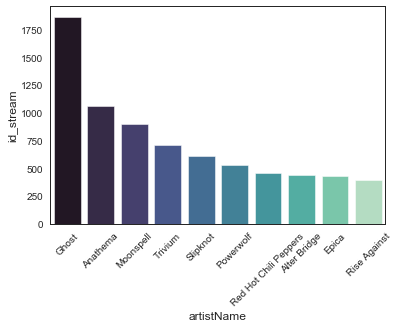

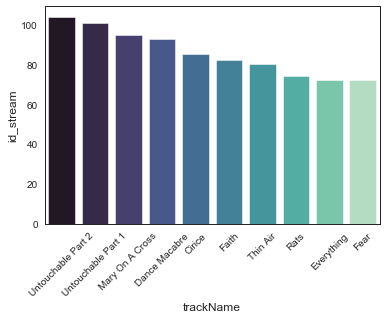

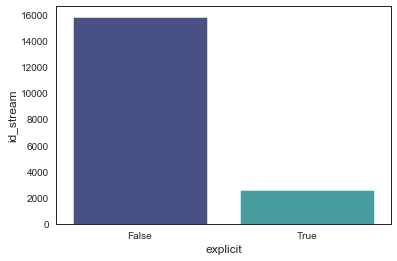

In [28]:
plt.style.use('ggplot')
sns.set_style('white')
for var in categorical:
    df = df_clean.copy()
    
    fig, ax = plt.subplots()
    if df[var].nunique() > 20:
            
        group = df.groupby(var, as_index = False)['id_stream'].count()
        top_10 = group.sort_values(by = 'id_stream', ascending = False)[:10].reset_index(drop = True)
        
        ax = sns.barplot(x = var, y = 'id_stream', data = top_10, palette = 'mako')
        ax.set_xticklabels(top_10[var], rotation = 45)
    else:
        group = df.groupby(var, as_index = False)['id_stream'].count()
        count = group.sort_values(by = 'id_stream', ascending = False)
        sns.barplot(x = var, y = 'id_stream', data = count, palette = 'mako')

### 3.2 Time variables

In [29]:
time

['timeStamp',
 'streamDate',
 'streamTime',
 'streamYear',
 'streamMonth',
 'streamDay',
 'streamHour',
 'streamWeekDay',
 'streamWeekDay_str']

In [31]:
time_series_features = pd.DataFrame(df_clean.groupby('streamDate').agg({'id_stream':['count'],
                                                                        'valence': ['mean'],
                                                                        'popularity': ['mean']}).reset_index())
time_series_features['streamDate'] = pd.to_datetime(time_series_features.streamDate)
time_series_features.set_index('streamDate', inplace = True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB52DA3DC8>,
      dtype=object)

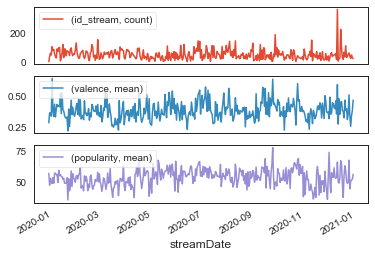

In [35]:
time_series_features.plot(subplots = True)
plt.show()

In [32]:
january_streams = time_series_features['01-01-2020':'31-01-2020']

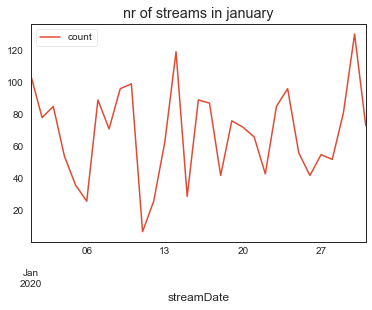

In [34]:
january_streams.id_stream.plot(title = 'nr of streams in january')

<Figure size 2160x720 with 0 Axes>

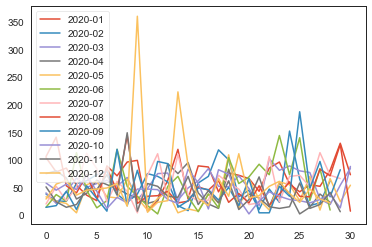

In [52]:
# dummy dataframe
counts = pd.DataFrame()

# Select data for each month and concatenate with counts 
for month in ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
              '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12']:
    counts_per_year = time_series_features.loc[month, [('id_stream', 'count')]].reset_index(drop=True)
    counts_per_year.columns = ['counts']
    counts_per_year.rename(columns={"counts": month}, inplace=True)
    counts = pd.concat([counts, counts_per_year], axis=1)
    
    #print(counts_per_year)
    
# Plot prices
plt.figure(figsize=(30,10))
counts.plot()
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB55A81588>,
      dtype=object)

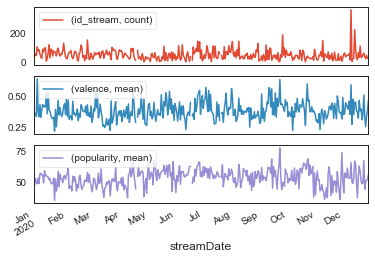

In [55]:
all_days = time_series_features.asfreq('D')

all_days.plot(subplots = True)
plt.show()

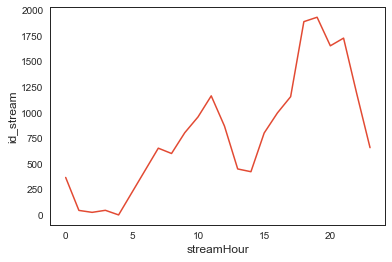

In [84]:
plot = df_clean.groupby('streamHour')['id_stream'].count().reset_index(drop = False)

ax = sns.lineplot(data = plot, x = 'streamHour', y = 'id_stream')

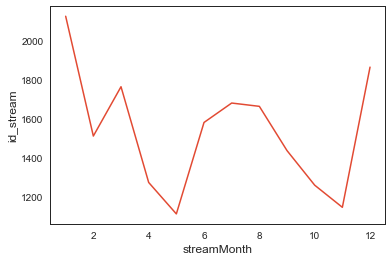

In [166]:
# Stream by month
plot = df_clean.groupby('streamMonth')['id_stream'].count().reset_index(drop = False)

ax = sns.lineplot(data = plot, x = 'streamMonth', y = 'id_stream')

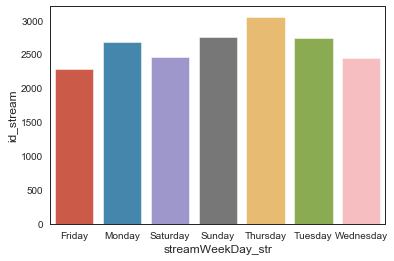

In [87]:
# Stream by weekday
plot = df_clean.groupby('streamWeekDay_str')['id_stream'].count().reset_index(drop = False)

ax = sns.barplot(data = plot, x = 'streamWeekDay_str', y = 'id_stream')

In [173]:
df_count_date = df_clean.groupby('streamDate')['id_stream'].count().reset_index()
df_count_date

,streamDate,id_stream
0,2019-12-28,1
1,2019-12-29,37
2,2019-12-30,59
3,2019-12-31,47
4,2020-01-01,104
...,...,...
360,2020-12-25,39
361,2020-12-26,23
362,2020-12-27,47
363,2020-12-28,29


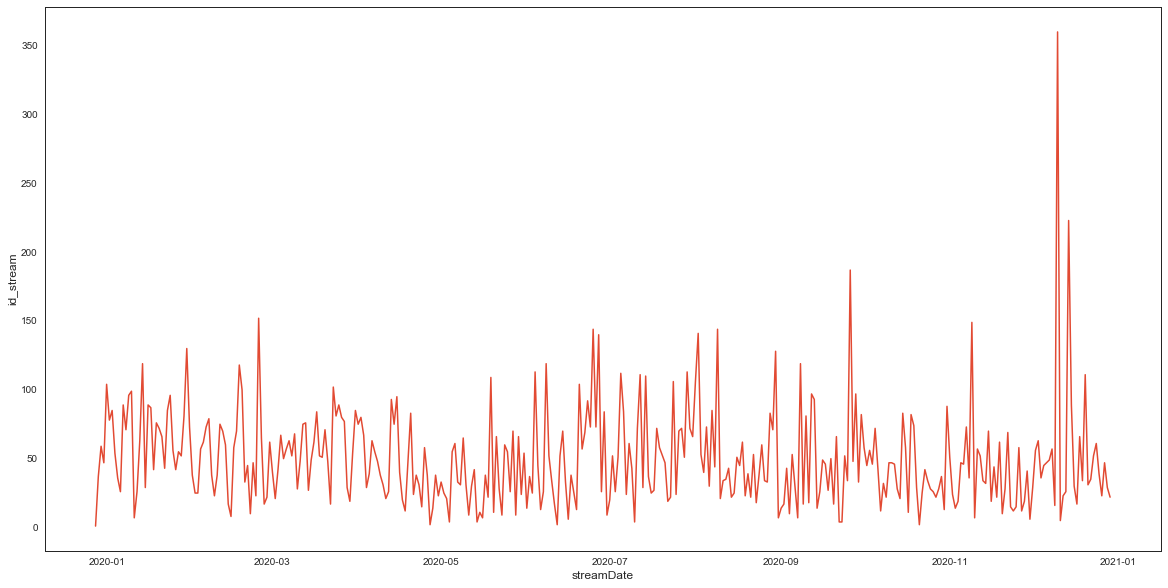

In [178]:
fig = plt.figure(figsize = (20,10))
sns.lineplot(data = df_count_date,x = 'streamDate', y = 'id_stream')

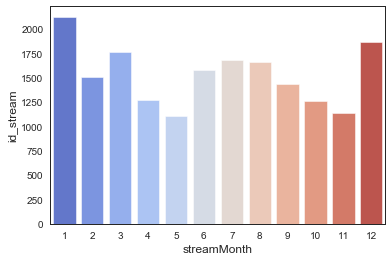

In [198]:
plot_month = df_clean.groupby('streamMonth')['id_stream'].count().reset_index()

sns.barplot(data = plot_month,x = 'streamMonth', y = 'id_stream', palette = 'coolwarm')

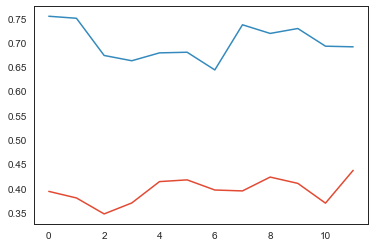

In [199]:
plot_month = df_clean.groupby(['streamMonth'])['valence', 'energy'].mean().reset_index()
plot_month

plt.plot(plot_month['valence'])
plt.plot(plot_month['energy'])